In [458]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Untagged data

These data were written out from the clean_content.py script where the taxons column was empty. 
- Here we assume the taxon column was empty because the content item has not been tagged.

In [459]:
#read in untagged content to describe content with no taxons
untagged = pd.read_csv('../../data/untagged_content.csv')

In [460]:
print("There are {} rows in the untagged content data".
      format(untagged.shape[0]))
print("There are {} unique content items in the untagged content data".
      format(untagged.content_id.nunique()))

There are 57337 rows in the untagged content data
There are 57123 unique content items in the untagged content data


In [461]:
untagged.columns

Index(['Unnamed: 0', 'base_path', 'content_id', 'description', 'details',
       'document_type', 'first_published_at', 'locale',
       'primary_publishing_organisation', 'publishing_app', 'taxons', 'title',
       'body'],
      dtype='object')

In [462]:
#convert string dates to timestamp for time series analyses (see below)
print(type(untagged['first_published_at'][0]))
untagged['first_published_at'] = pd.to_datetime(untagged['first_published_at'])
print(type(untagged['first_published_at'][0]))

<class 'str'>
<class 'pandas._libs.tslib.Timestamp'>


In [463]:
#use timestamp as index in untagged data for plots
untagged.index = untagged['first_published_at'] 

# Taxon data

Taxons data is a row for each taxon with columns for the taxon_id/taxon title at each level. So, for example, if an item has only been tagged to level1 then level2 and subsequent levels will be missing. If an item was tagged to level3, the level2 and level1 columns have been filled recursively. 

A taxon in taxons is identified through content_id

In [464]:
#read in taxon file which was cleaned from raw using clean_taxons.py
taxons = pd.read_csv('../../data/clean_taxons.csv')

In [465]:
taxons.columns

Index(['Unnamed: 0', 'base_path', 'content_id', 'taxon_name', 'level1',
       'level2tax_id', 'level3tax_id', 'level4tax_id', 'level1taxon',
       'level2taxon', 'level3taxon', 'level4taxon'],
      dtype='object')

In [466]:
taxons = taxons[['base_path','content_id','taxon_name','level1taxon','level2taxon','level3taxon','level4taxon']].copy()

#### This section needs to be moved to clean_taxons.py

In [467]:
#For top taxons (level1) ensure that taxon)name is in level1taxon column instead of Nan
taxons['level1taxon'] = taxons['level1taxon'].fillna(taxons['taxon_name'])

In [468]:
#function to combine boolean series into one
import functools
def conjunction(*conditions):
    return functools.reduce(np.logical_and, conditions)

In [469]:
#make a copy of taxons for working with
taxonslevels = taxons.copy()
#define the condition 
cond = conjunction(taxonslevels['level2taxon'].isna(), taxonslevels['level1taxon'] != taxonslevels['taxon_name'])
#change the values of the column if the condition is met to the taxon-name, otherwise the original string
taxonslevels['level2taxon'] = np.where(cond, taxonslevels['taxon_name'], taxonslevels['level2taxon'])

In [470]:
cond = conjunction(taxons['level2taxon'] != taxons['taxon_name'], taxons['level3taxon'].isna(), taxons['level2taxon'].notnull())
taxonslevels['level3taxon'] = np.where(cond, taxonslevels['taxon_name'], taxonslevels['level3taxon'])

In [471]:
cond = conjunction(taxons['level3taxon'] != taxons['taxon_name'], taxons['level2taxon'] != taxons['taxon_name'], taxons['level4taxon'].isna(), taxons['level3taxon'].notnull())
taxonslevels['level4taxon'] = np.where(cond, taxonslevels['taxon_name'], taxonslevels['level4taxon'])

In [472]:
#create new column for last taxon level
taxonslevels['level5taxon'] = np.nan
cond = conjunction(taxons['level4taxon'] != taxons['taxon_name'], taxons['level3taxon'] != taxons['taxon_name'], taxons['level2taxon'] != taxons['taxon_name'], taxons['level4taxon'].notnull())
taxonslevels['level5taxon'] = np.where(cond, taxonslevels['taxon_name'], taxonslevels['level5taxon'])

In [473]:
#copy the working df back to taxons
taxons = taxonslevels.copy()


# Content data

These data were created in clean_content.py so that each row represents a single content-taxon pair. There can be multiple rows for a content item (content_id) if it has been tagged to multiple taxons (taxon_id).  

In [474]:
#read in content items file which was cleaned from raw using clean_content.py

content = pd.read_csv('../../data/clean_content.csv.gz', compression='gzip')

In [475]:
content.columns

Index(['Unnamed: 0', 'base_path', 'content_id', 'description', 'details',
       'document_type', 'first_published_at', 'locale',
       'primary_publishing_organisation', 'publishing_app', 'title', 'body',
       'combined_text', 'variable', 'taxon_id'],
      dtype='object')

## All content with no filtering by taxon

In [476]:
allcontent_taxons = pd.merge(
    left=content, 
    right=taxons, 
    left_on='taxon_id', #which taxon is the content item tagged to
    right_on='content_id', #what is the id of that taxon
    how='outer', #keep everything for checking merge
    indicator=True #so we can filter by match type
)

In [477]:
allcontent_taxons.shape

(336967, 24)

In [478]:
#tidy column names
allcontent_taxons.rename(columns={'base_path_x': 'base_path', 
                               'content_id_x': 'content_id'}, inplace=True)

#### All content with no filtering by taxon

In [479]:
#intersection of join only
allcontent_taxons = allcontent_taxons[allcontent_taxons._merge == 'both']

In [480]:
allcontent_taxons.shape

(232526, 24)

In [481]:
#remove duplicates if both content_id and taxon_id are the same. 
allcontent_taxons = allcontent_taxons.drop_duplicates(subset = ['content_id', 'taxon_id'])

In [482]:
allcontent_taxons.shape

(232149, 24)

## Filter by taxon to exclude specific taxons from prediction activities

Current approach: Take out World and Corporate top taxons   
Must consider that the data which we will predict on needs to come from the same population as training data and it is hard to filter the unlabelled data to remove World & Corporate (unless they are perfectly predicted by a meta var such as documnet type). It may be safer to keep them in the training data, predict on all data and act differently if World/Corporate is predicted?

In [483]:
taxons.shape

(4530, 8)

In [484]:
taxons = taxons[taxons.level1taxon != 'World']
print("Taxons shape after deleting 'World' top taxons: {}".format(taxons.shape))

Taxons shape after deleting 'World' top taxons: (2028, 8)


In [485]:
taxons = taxons[taxons.level1taxon != 'Corporate information']
print("Taxons shape after deleting 'corporate information' top taxons: {}".format(taxons.shape))

Taxons shape after deleting 'corporate information' top taxons: (2027, 8)


Is it possible that corporate information has already been excluded from the taxons file? Need to re-consider this approach

In [486]:
content_taxons = pd.merge(
    left=content, 
    right=taxons, 
    left_on='taxon_id', 
    right_on='content_id', 
    how='outer', 
    indicator=True
)

In [487]:
print(content_taxons['_merge'].value_counts())
print("There are {} tagged content items/taxon combinations with a matching taxon"
      .format(content_taxons['_merge'].value_counts()[2]))
print("There are {} content items/taxon combinations without a matching taxon. Are these untagged content?"
      .format(content_taxons['_merge'].value_counts()[0]))
print("There are {} /taxons with nothing tagged to them"
      .format(content_taxons['_merge'].value_counts()[1]))


both          229461
left_only     106154
right_only       105
Name: _merge, dtype: int64
There are 229461 tagged content items/taxon combinations with a matching taxon
There are 106154 content items/taxon combinations without a matching taxon. Are these untagged content?
There are 105 /taxons with nothing tagged to them


### Explore the left_only content

Need to add this to untagged data...

In [488]:
content_only_taxons = content_taxons[['base_path_x','combined_text','details','taxon_id']][content_taxons._merge == 'left_only']

In [489]:
print("There are {} taxons represented in the {} content item/taxon combinations which have no corresponding taxon in the taxon data"
      .format(content_only_taxons.taxon_id.nunique(), content_only_taxons.shape[0]))

There are 2010 taxons represented in the 106154 content item/taxon combinations which have no corresponding taxon in the taxon data


In [490]:
print("There are {} content items/taxon combinations with missing taxon because these were removed during taxon_clean.py"
      .format(content_only_taxons[content_only_taxons.taxon_id.isnull()].shape[0]))

There are 0 content items/taxon combinations with missing taxon because these were removed during taxon_clean.py


In [491]:
#save out for devs to check reason these do not have a match in taxon file
#content_only_taxons.to_csv('../../data/content_with_taxonid_no_matching_taxon.csv', 
                           #index=False)

In [492]:
# np.savetxt('../../data/taxonid_no_matching_taxon.gz', 
#            content_only_taxons.taxon_id.unique(),fmt='%5s', delimiter=',')

Devs did some spot checks on these and some of these taxons were not part of the topic taxonomy so did not have a match in the topic taxonomy file. Others are in the World branch of the taxonomy.

need to add these to untaggedd population


## Tidy the content-taxon df

In [493]:
content_taxons.shape

(335720, 24)

#### tidy columns

In [494]:
content_taxons.columns

Index(['Unnamed: 0', 'base_path_x', 'content_id_x', 'description', 'details',
       'document_type', 'first_published_at', 'locale',
       'primary_publishing_organisation', 'publishing_app', 'title', 'body',
       'combined_text', 'variable', 'taxon_id', 'base_path_y', 'content_id_y',
       'taxon_name', 'level1taxon', 'level2taxon', 'level3taxon',
       'level4taxon', 'level5taxon', '_merge'],
      dtype='object')

In [495]:
#drop some cols
content_taxons = content_taxons.drop(['Unnamed: 0', 'variable', 'base_path_y', 
                                      'content_id_y'], axis=1)

In [496]:
#rename some cols
content_taxons.rename(columns={'base_path_x': 'base_path', 
                               'content_id_x': 'content_id'}, inplace=True)

## Filter content-taxons data:
- remove duplicates
- remove mismatches from merge

In [497]:
#count duplicates
print("There are {} rows in the data before filtering".
      format(content_taxons.shape[0]))
print("There are {} unique content items in the data before filtering".
      format(content_taxons.content_id.nunique()))


There are 335720 rows in the data before filtering
There are 140103 unique content items in the data before filtering


In [498]:
# Drop any rows which were not perfectly matched in taxons and content

content_taxons_filtered = content_taxons[content_taxons._merge == 'both']

print("There are {} rows in the taxon-level data after filtering out mismatches".
      format(content_taxons_filtered.shape[0]))
print("There are {} unique content items in the taxon-level data after filtering out mismatches".
      format(content_taxons_filtered.content_id.nunique()))
print("There were {} rows dropped because of mismatching"
      .format(content_taxons.shape[0] - content_taxons_filtered.shape[0]))
print("There were {} unique content items dropped because of mismatching"
      .format(content_taxons.content_id.nunique() - content_taxons_filtered.content_id.nunique()))

There are 229461 rows in the taxon-level data after filtering out mismatches
There are 127320 unique content items in the taxon-level data after filtering out mismatches
There were 106259 rows dropped because of mismatching
There were 12783 unique content items dropped because of mismatching


In [499]:
print("Before removing mismatches, there were {} duplicates content items, both with matching content_id "
      "and taxon_id"
      .format(content_taxons[content_taxons.duplicated(['content_id', 'taxon_id'])].shape[0]))
print("After removing mismatches, there were {} duplicates content items, both with matching "
      "content_id and taxon_id"
      .format(content_taxons_filtered[content_taxons_filtered.
                                      duplicated(['content_id', 'taxon_id'])].shape[0]))


Before removing mismatches, there were 956 duplicates content items, both with matching content_id and taxon_id
After removing mismatches, there were 377 duplicates content items, both with matching content_id and taxon_id


In [500]:
#drop duplicates
content_taxons_dedup = content_taxons_filtered.drop_duplicates(subset = ['content_id', 'taxon_id'])

In [501]:
print("There were {} additional rows dropped due to duplicate content_id/taxon_id combination"
      .format(content_taxons_filtered.shape[0] - content_taxons_dedup.shape[0]))
print("There were {} additional content items dropped due to duplicate content_id/taxon_id combination"
      .format(content_taxons_filtered.content_id.nunique() - content_taxons_dedup.content_id.nunique()))

There were 377 additional rows dropped due to duplicate content_id/taxon_id combination
There were 0 additional content items dropped due to duplicate content_id/taxon_id combination


In [502]:
#assert content_taxons_dedup.shape == (2029084, 18)
content_taxons_dedup.shape

(229084, 20)

In [503]:
#content_taxons_dedup.head()

# Taxons

In [504]:
#Count taxons by level1 and level2
mask = taxons['level1taxon'].notnull() & taxons['level2taxon'].isnull()

print("There are {} out of {} taxons with a level2"
      .format(sum(taxons['level2taxon'].notnull()), taxons.shape[0]))
print("There are {} out of {} taxons with a level1 tag, but no level2 tag"
      .format(sum(mask), taxons.shape[0]))
taxons

There are 2008 out of 2027 taxons with a level2
There are 19 out of 2027 taxons with a level1 tag, but no level2 tag


,base_path,content_id,taxon_name,level1taxon,level2taxon,level3taxon,level4taxon,level5taxon
0,/business/taxon,495afdb6-47be-4df1-8b38-91c8adb1eefc,Business,Business,NaN,NaN,NaN,NaN
2,/crime-justice-and-law,ba951b09-5146-43be-87af-44075eac3ae9,"Crime, justice and law","Crime, justice and law",NaN,NaN,NaN,NaN
3,/defence,e491505c-77ae-45b2-84be-8c94b94f6a2b,Defence,Defence,NaN,NaN,NaN,NaN
4,/childcare-parenting/entering-staying-uk,ba3a9702-da22-487f-86c1-8334a730e559,Entering and staying in the UK,Entering and staying in the UK,NaN,NaN,NaN,NaN
5,/environment,3cf97f69-84de-41ae-bc7b-7e2cc238fa58,Environment,Environment,NaN,NaN,NaN,NaN
6,/going-and-being-abroad,9597c30a-605a-4e36-8bc1-47e5cdae41b3,Going and being abroad,Going and being abroad,NaN,NaN,NaN,NaN
7,/government/taxon,e48ab80a-de80-4e83-bf59-26316856a5f9,Government,Government,NaN,NaN,NaN,NaN
8,/health-and-social-care,8124ead8-8ebc-4faf-88ad-dd5cbcc92ba8,Health and social care,Health and social care,NaN,NaN,NaN,NaN
9,/housing-local-and-community,4794066e-e3cc-425e-8cc4-e7ff3edb4c39,"Housing, local and community","Housing, local and community",NaN,NaN,NaN,NaN
10,/international,37d0fa26-abed-4c74-8835-b3b51ae1c8b2,International,International,NaN,NaN,NaN,NaN


### How many taxons at each level?

In [505]:
level1_only = taxons[taxons['level1taxon'].notnull() & taxons['level2taxon'].isnull()]
level2_only = taxons[taxons['level2taxon'].notnull() & taxons['level3taxon'].isnull()]
level3_only = taxons[taxons['level3taxon'].notnull() & taxons['level4taxon'].isnull()]
level4_only = taxons[taxons['level4taxon'].notnull() & taxons['level5taxon'].isnull()]
level5_only = taxons[taxons['level5taxon'].notnull()]

print("Number of taxons at level1 = {}".format(level1_only.shape[0]))
print("Number of taxons at level2 = {}".format(level2_only.shape[0]))
print("Number of taxons at level3 = {}".format(level3_only.shape[0]))
print("Number of taxons at level4 = {}".format(level4_only.shape[0]))
print("Number of taxons at level5 = {}".format(level5_only.shape[0]))

Number of taxons at level1 = 19
Number of taxons at level2 = 217
Number of taxons at level3 = 687
Number of taxons at level4 = 882
Number of taxons at level5 = 222


### How many content items at each level?

In [506]:
level1_only = content_taxons_dedup[content_taxons_dedup['level1taxon'].notnull() & content_taxons_dedup['level2taxon'].isnull()]
level2_only = content_taxons_dedup[content_taxons_dedup['level2taxon'].notnull() & content_taxons_dedup['level3taxon'].isnull()]
level3_only = content_taxons_dedup[content_taxons_dedup['level3taxon'].notnull() & content_taxons_dedup['level4taxon'].isnull()]
level4_only = content_taxons_dedup[content_taxons_dedup['level4taxon'].notnull() & content_taxons_dedup['level5taxon'].isnull()]
level5_only = content_taxons_dedup[content_taxons_dedup['level5taxon'].notnull()]

print("Number of times content items tagged to level1 = {}".format(level1_only.shape[0]))
print("Number of times content items tagged to level2 = {}".format(level2_only.shape[0]))
print("Number of times content items tagged to level3 = {}".format(level3_only.shape[0]))
print("Number of times content items tagged to level4 = {}".format(level4_only.shape[0]))
print("Number of times content items tagged to level5 = {}".format(level5_only.shape[0]))
print("")
print("Number of unique content items tagged to level1 = {}".format(level1_only.content_id.nunique()))
print("Number of unique content items tagged to level2 = {}".format(level2_only.content_id.nunique()))
print("Number of unique content items tagged to level3 = {}".format(level3_only.content_id.nunique()))
print("Number of unique content items tagged to level4 = {}".format(level4_only.content_id.nunique()))
print("Number of unique content items tagged to level5 = {}".format(level5_only.content_id.nunique()))

Number of times content items tagged to level1 = 32034
Number of times content items tagged to level2 = 128372
Number of times content items tagged to level3 = 54732
Number of times content items tagged to level4 = 11942
Number of times content items tagged to level5 = 2004

Number of unique content items tagged to level1 = 30125
Number of unique content items tagged to level2 = 89081
Number of unique content items tagged to level3 = 45240
Number of unique content items tagged to level4 = 9926
Number of unique content items tagged to level5 = 1639


### Number of tags per content item at each level

In [507]:
level1_only.groupby('content_id').size().sort_values(ascending=True).describe()

count    30125.000000
mean         1.063369
std          0.250350
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
dtype: float64

In [508]:
level2_only.groupby('content_id').size().sort_values(ascending=True).describe()

count    89081.000000
mean         1.441070
std          0.821392
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         35.000000
dtype: float64

In [509]:
level3_only.groupby('content_id').size().sort_values(ascending=True).describe()

count    45240.000000
mean         1.209814
std          0.607367
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
dtype: float64

In [510]:
level4_only.groupby('content_id').size().sort_values(ascending=True).describe()

count    9926.000000
mean        1.203103
std         0.499122
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        11.000000
dtype: float64

In [511]:
level5_only.groupby('content_id').size().sort_values(ascending=True).describe()

count    1639.000000
mean        1.222697
std         0.542299
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         5.000000
dtype: float64

## Level1  taxons

Expecting 19 top taxons (plus `None`)

In [513]:
assert content_taxons_dedup.level1taxon.nunique() == 19

print("There are {} unique taxon names in the level 1 taxon"
      .format(content_taxons_dedup.level1taxon.nunique()))

set(content_taxons_dedup.level1taxon)

There are 19 unique taxon names in the level 1 taxon


{'Business',
 'Crime, justice and law',
 'Defence',
 'Education, training and skills',
 'Entering and staying in the UK',
 'Environment',
 'Going and being abroad',
 'Government',
 'Health and social care',
 'Housing, local and community',
 'International',
 'Life circumstances',
 'Money',
 "Parenting, childcare and children's services ",
 'Regional and local government',
 'Society and culture',
 'Transport',
 'Welfare',
 'Work'}

In [514]:
topfreq = content_taxons_dedup.groupby('level1taxon').size()
topfreq.sort_values(ascending=False)

level1taxon
Business                                         48397
Environment                                      29199
Government                                       23809
Society and culture                              15476
Health and social care                           14886
Money                                            13722
International                                    13409
Housing, local and community                     10637
Defence                                          10363
Crime, justice and law                            9998
Education, training and skills                    9790
Regional and local government                     9065
Transport                                         8468
Work                                              5132
Welfare                                           3164
Going and being abroad                            1841
Parenting, childcare and children's services      1122
Entering and staying in the UK                     31

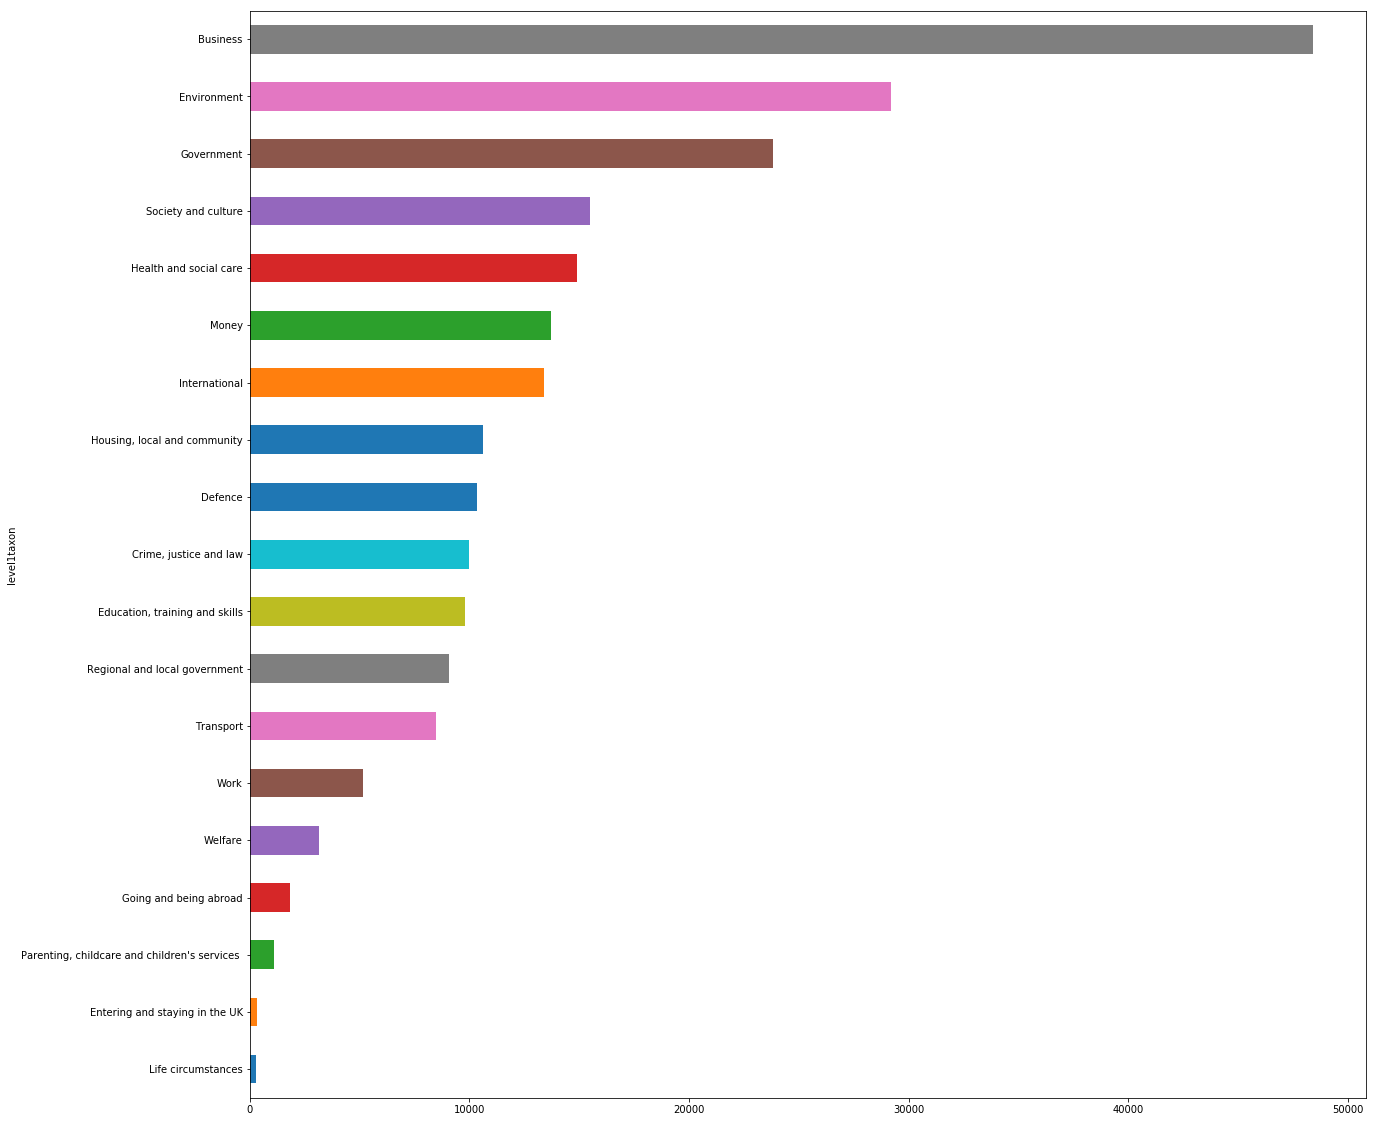

In [515]:
topfreq.sort_values().plot(kind = 'barh', figsize=(20, 20))

Formally, Kendall's τ coefficient is defined as:

$${\tau ={\frac {({\text{number of concordant pairs}})-({\text{number of discordant pairs}})}{N(N-1)/2}}}$$

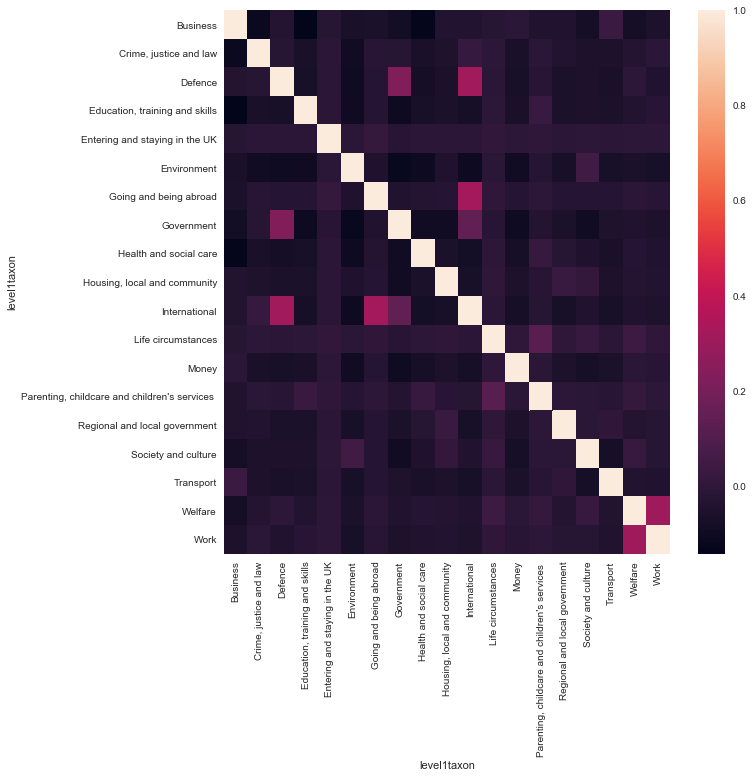

In [574]:
level1_counts= content_taxons_dedup.groupby(['content_id', 'level1taxon']).size().unstack(fill_value=0)
level1_corr=level1_counts.corr(method = "kendall")

# plot the heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.set()
sns.heatmap(level1_corr, 
        xticklabels=level1_corr.columns,
        yticklabels=level1_corr.columns)

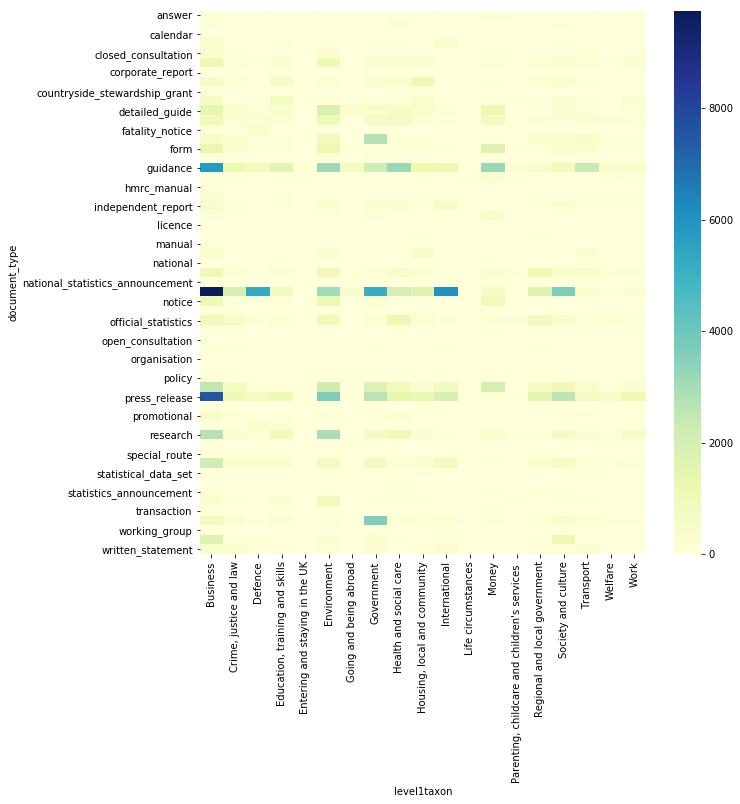

In [516]:
top_doctype = pd.crosstab(content_taxons_dedup['document_type'], content_taxons_dedup['level1taxon'])
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(top_doctype, cmap = "YlGnBu")

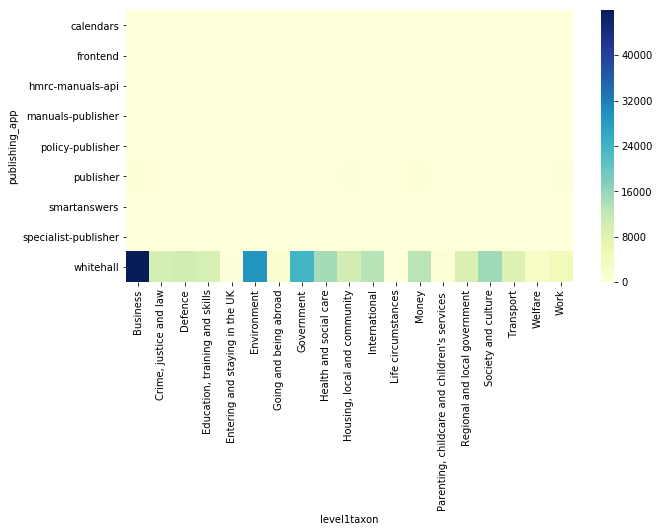

In [517]:
top_pubapp = pd.crosstab(content_taxons_dedup['publishing_app'], content_taxons_dedup['level1taxon'])
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(top_pubapp, cmap = "YlGnBu")

In [518]:
content_taxons_dedup.groupby('level1taxon').size().sort_values(ascending=False)

level1taxon
Business                                         48397
Environment                                      29199
Government                                       23809
Society and culture                              15476
Health and social care                           14886
Money                                            13722
International                                    13409
Housing, local and community                     10637
Defence                                          10363
Crime, justice and law                            9998
Education, training and skills                    9790
Regional and local government                     9065
Transport                                         8468
Work                                              5132
Welfare                                           3164
Going and being abroad                            1841
Parenting, childcare and children's services      1122
Entering and staying in the UK                     31

### Level 2 taxons

In [519]:
#assert content_taxons_dedup.level2taxon.nunique() == 103

print("There are {} unique taxon names in the level 2 taxon"
      .format(content_taxons_dedup.level2taxon.nunique()))

There are 209 unique taxon names in the level 2 taxon


In [520]:
second_freq = content_taxons_dedup.groupby('level2taxon').size().sort_values(ascending=False)

# Print as string to get around truncation

print(second_freq.to_string())



level2taxon
Business and enterprise                                                   13944
UK economy                                                                11140
Government efficiency, transparency and accountability                    11049
Trade and investment                                                       8969
Climate change and energy                                                  8403
Public health                                                              6697
National security                                                          5765
National Health Service                                                    5632
Foreign affairs                                                            5447
Housing planning and building                                              5358
Housing                                                                    5043
Community and society                                                      4918
Science and innovation      

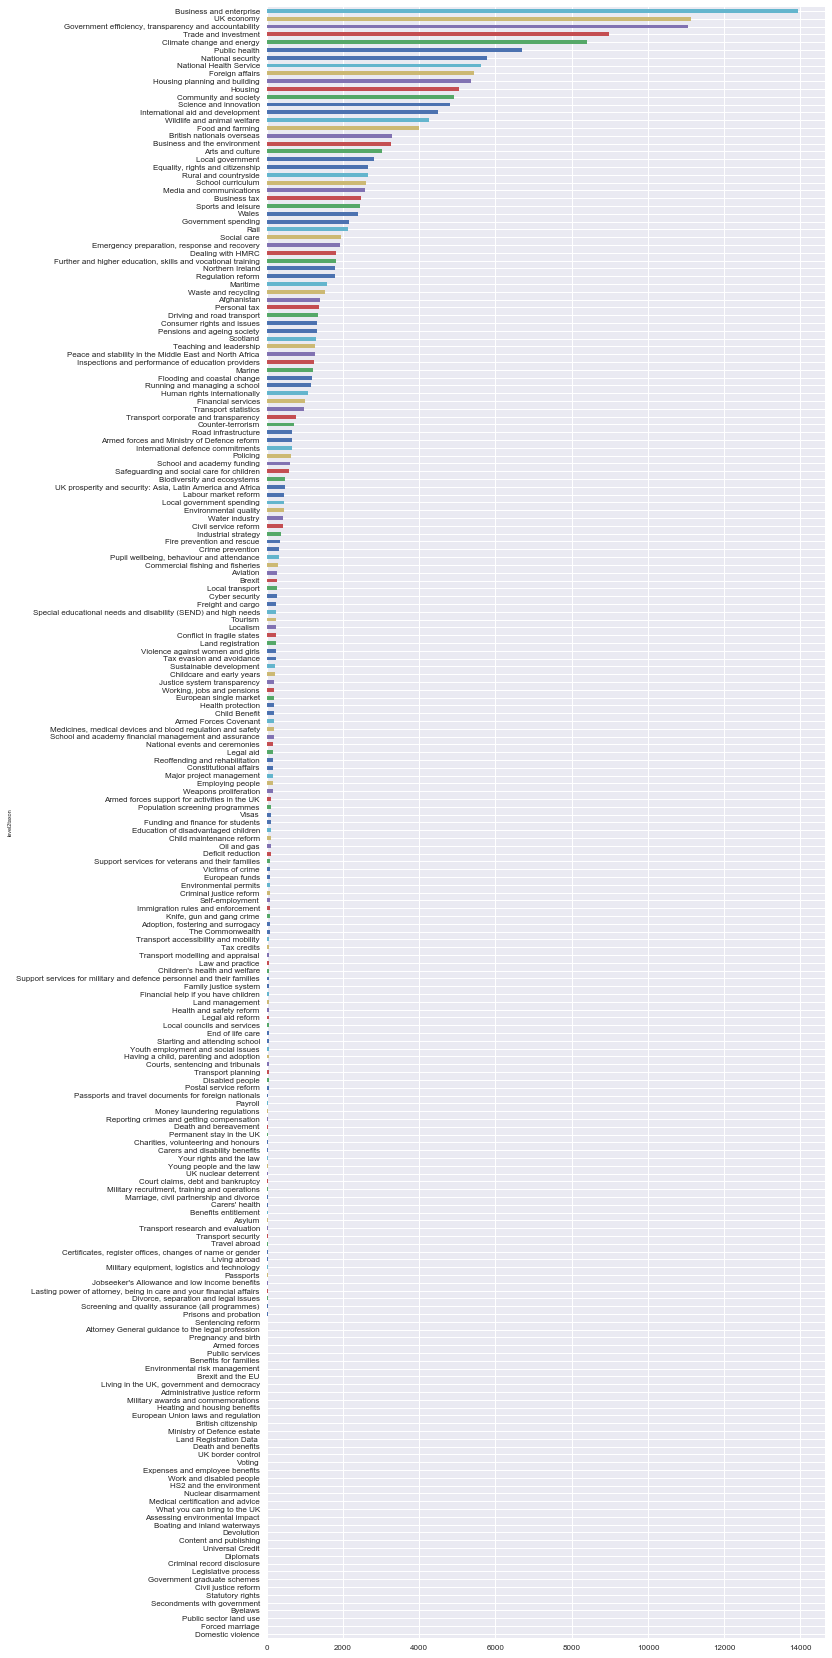

In [583]:
second_freq.sort_values().plot(kind = 'barh', figsize=(10,30), fontsize=8)

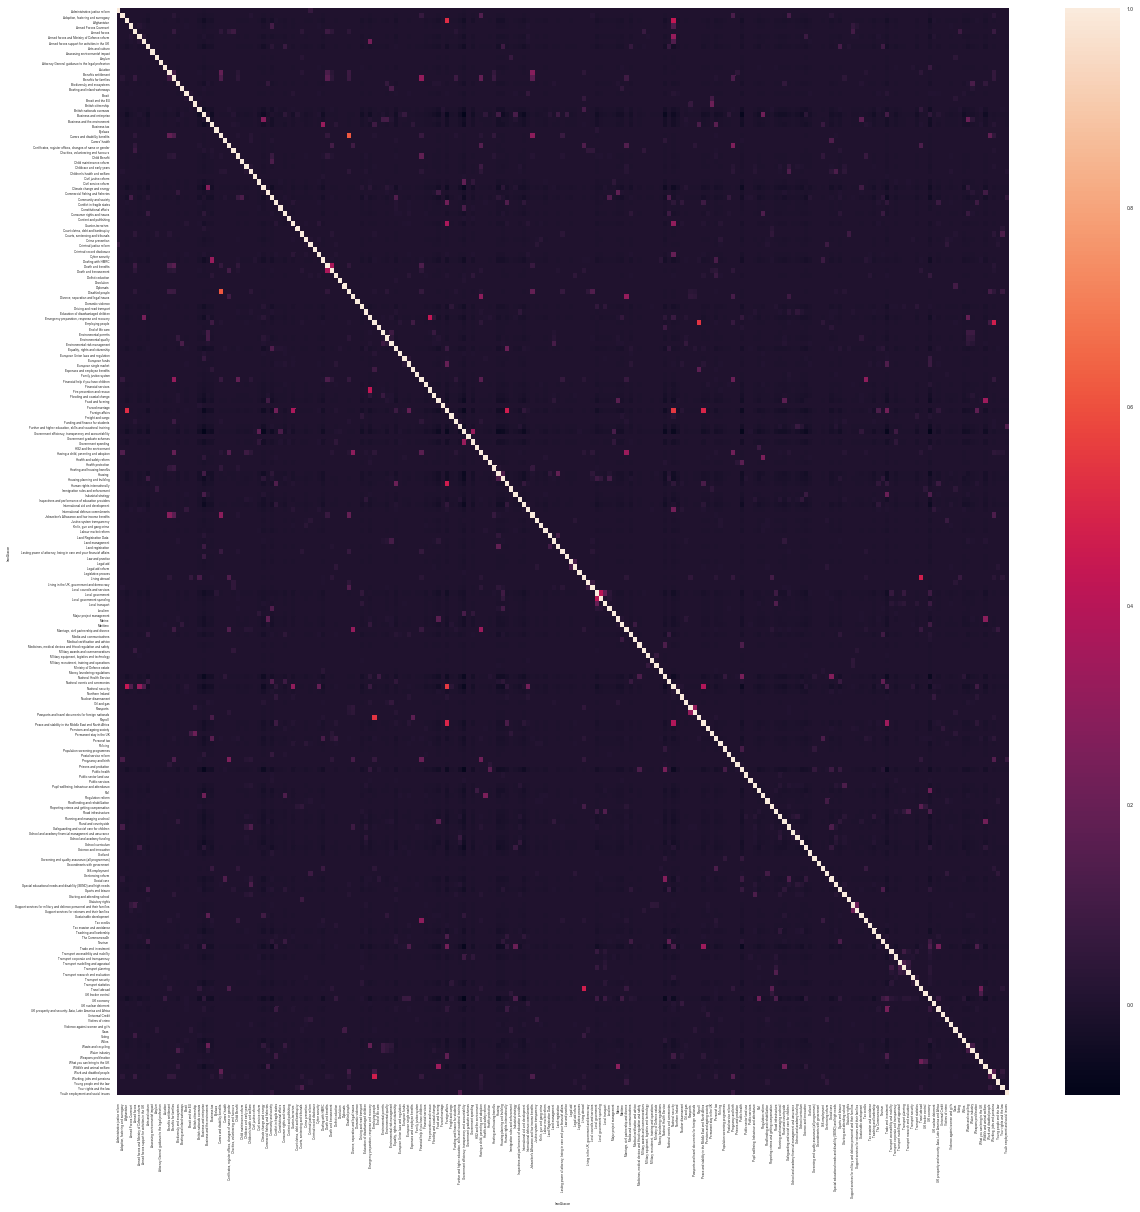

In [582]:
level2_counts= content_taxons_dedup.groupby(['content_id', 'level2taxon']).size().unstack(fill_value=0)
level2_corr=level2_counts.corr(method = "kendall")

# plot the heatmap
fig, ax = plt.subplots(figsize=(20,20))
sns.set(font_scale=0.5)
sns.heatmap(level2_corr, 
        xticklabels=level2_corr.columns,
        yticklabels=level2_corr.columns)

### Mutually exclusive taxon combinations (level1 and level2)

In [524]:
#Only keep rows where level1/level2 combination is unique
level2_dedup = content_taxons_dedup.drop_duplicates(subset = ['content_id', 'level1taxon', 'level2taxon']).copy()
#Identify and drop rows where level2 is missing
mask= pd.notnull(level2_dedup['level2taxon'])
level2_tagged = level2_dedup[mask]

In [525]:
#concatenate the name of each level2taxon for a single content item
level2_tagged = level2_tagged.groupby('content_id')['level2taxon'].apply(','.join).reset_index()
print("there are {} mutually exclusive combinations of level2 taxon combinations.".format(level2_tagged.level2taxon.nunique()))

there are 4097 mutually exclusive combinations of level2 taxon combinations.


There are 152 mutually exclusive combinations of level2 taxon combinations populated with more than 30 content items


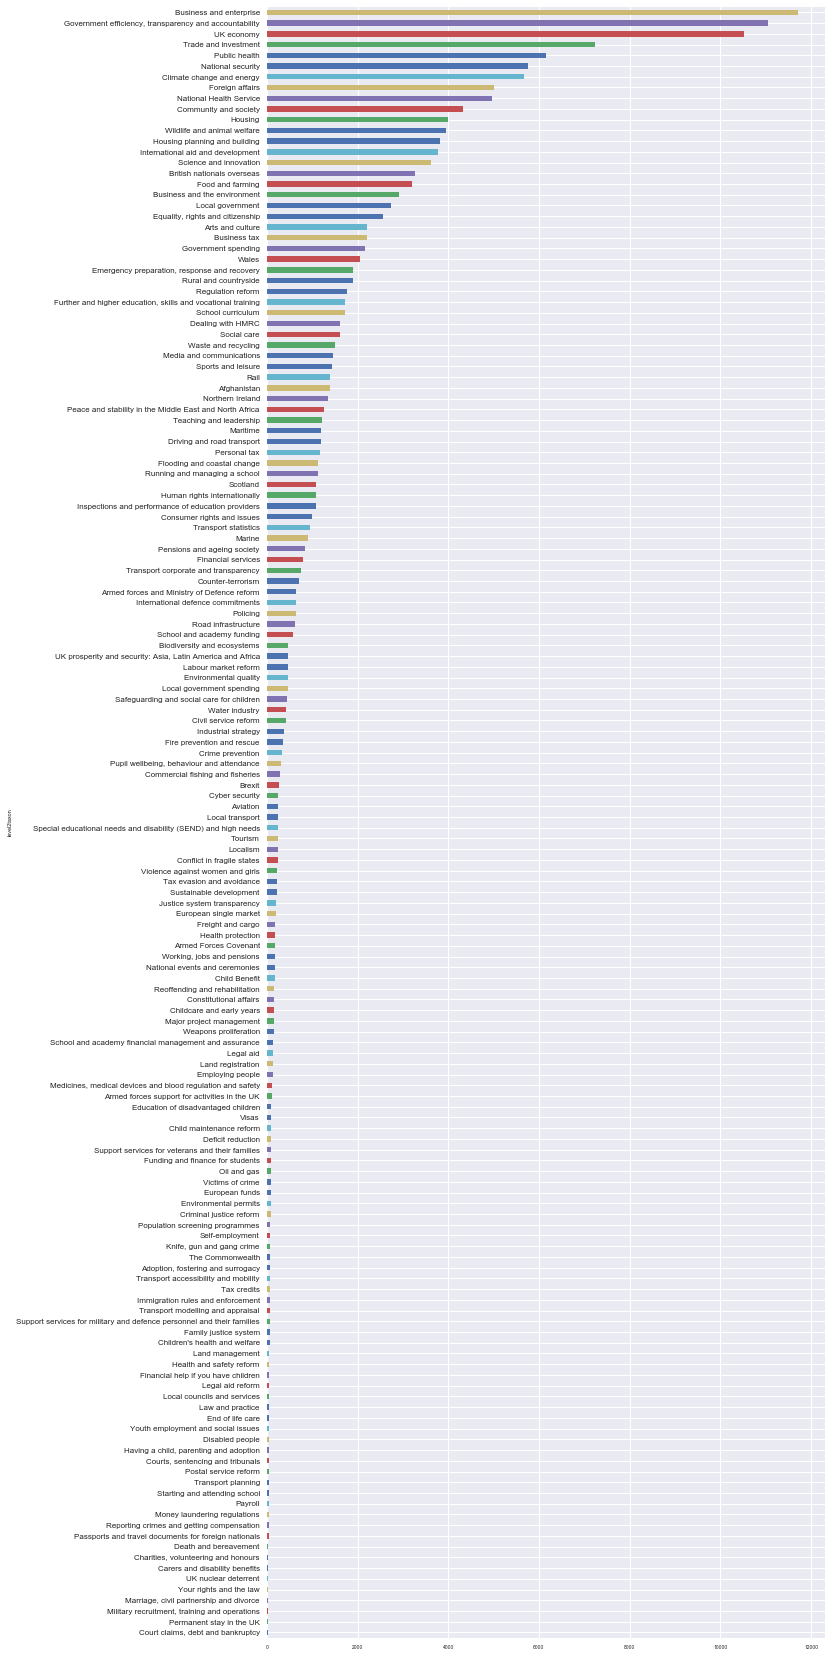

In [585]:
#Get frequency counts for each of the mutually exclusive taxon2 combinations
mutualex_freq = level2_tagged.groupby('level2taxon').size().sort_values(ascending=True)

#Keep those with higher frequency
mutualex_freq_top = mutualex_freq[mutualex_freq > 30]
print("There are {} mutually exclusive combinations of level2 taxon combinations populated with more than 30 content items".format(len(mutualex_freq_top)))

mutualex_freq_top.plot(kind = 'barh', figsize=(10,30))
plt.rc('ytick', labelsize=10)

In [579]:
# Print as string to get around truncation

print(mutualex_freq.to_string())

level2taxon
Domestic violence                                                             1
Public sector land use                                                        2
Byelaws                                                                       2
Secondments with government                                                   2
Forced marriage                                                               2
Government graduate schemes                                                   3
Statutory rights                                                              3
Civil justice reform                                                          3
Legislative process                                                           4
Criminal record disclosure                                                    4
Diplomats                                                                     4
Universal Credit                                                              5
Content and publishing      

# Document type distribution

## Compare document type in untagged, raw tagged, deduped-filtered tagged

the untagged content appears to have a different distribution of document type compared to the tagged content, both before and after filtering the World/Corporate categories and deduplication. 

For example, relatively few guidance , policy paper and research documents are untagged. World_news_story, foi releases are over-represented in untagged data compared to tagged data.

This is likely to result in a drop inaccuracy when moving from modelling data to predicting for untagged data.

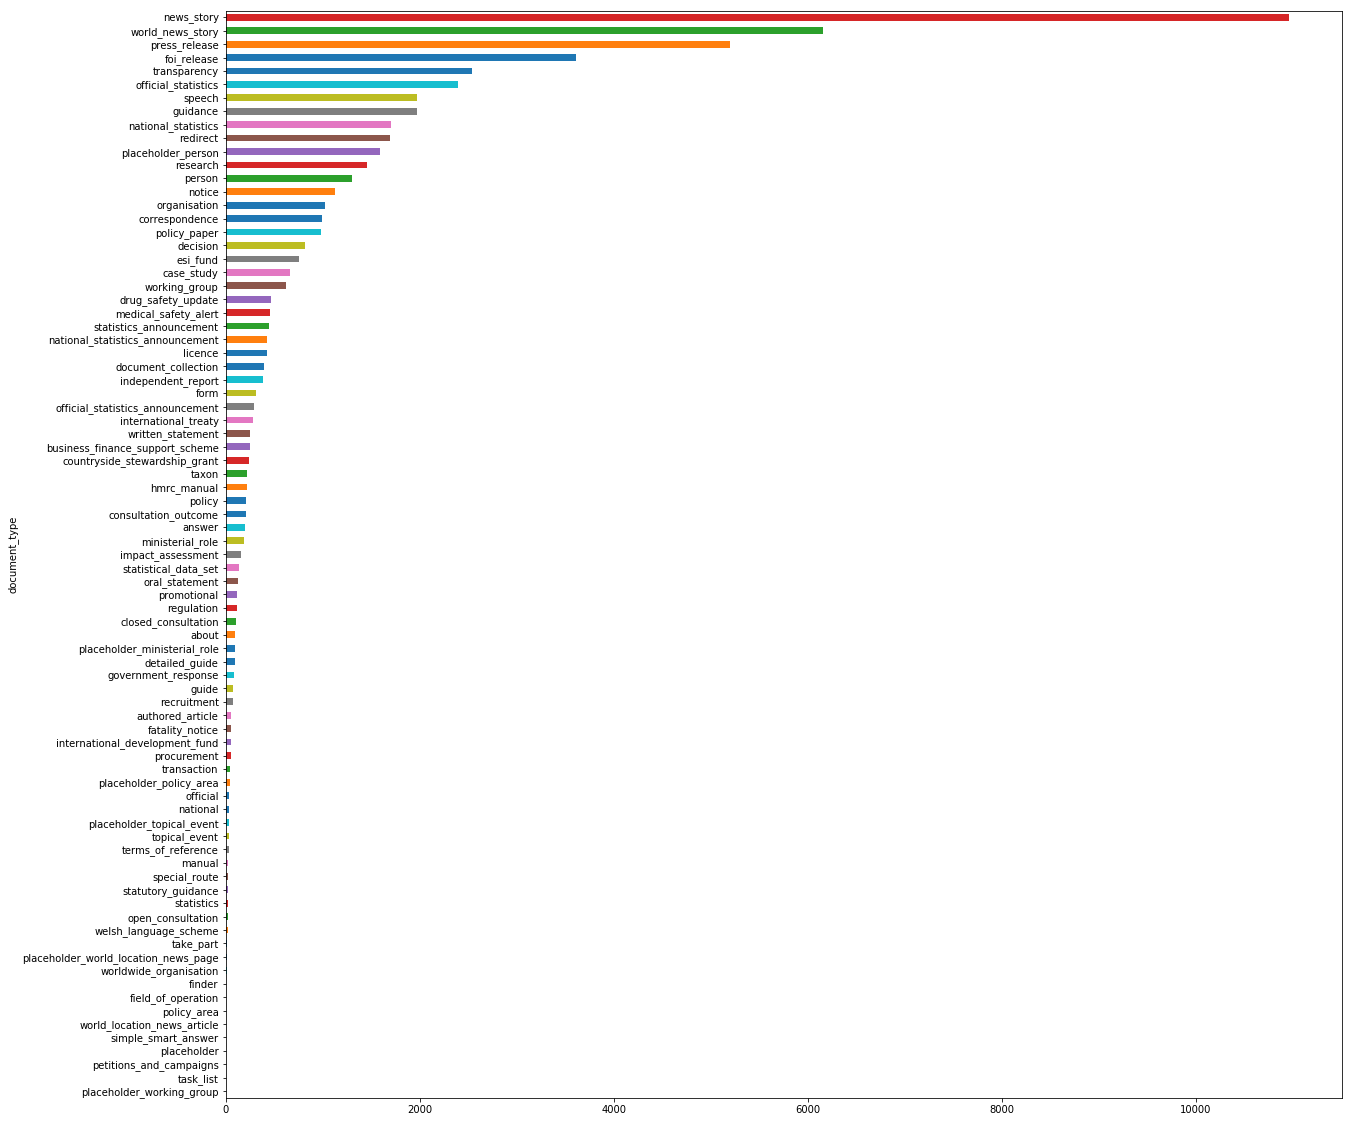

In [528]:
untagged.groupby('document_type').size().sort_values(ascending=True).plot(kind = 'barh', figsize=(20, 20))

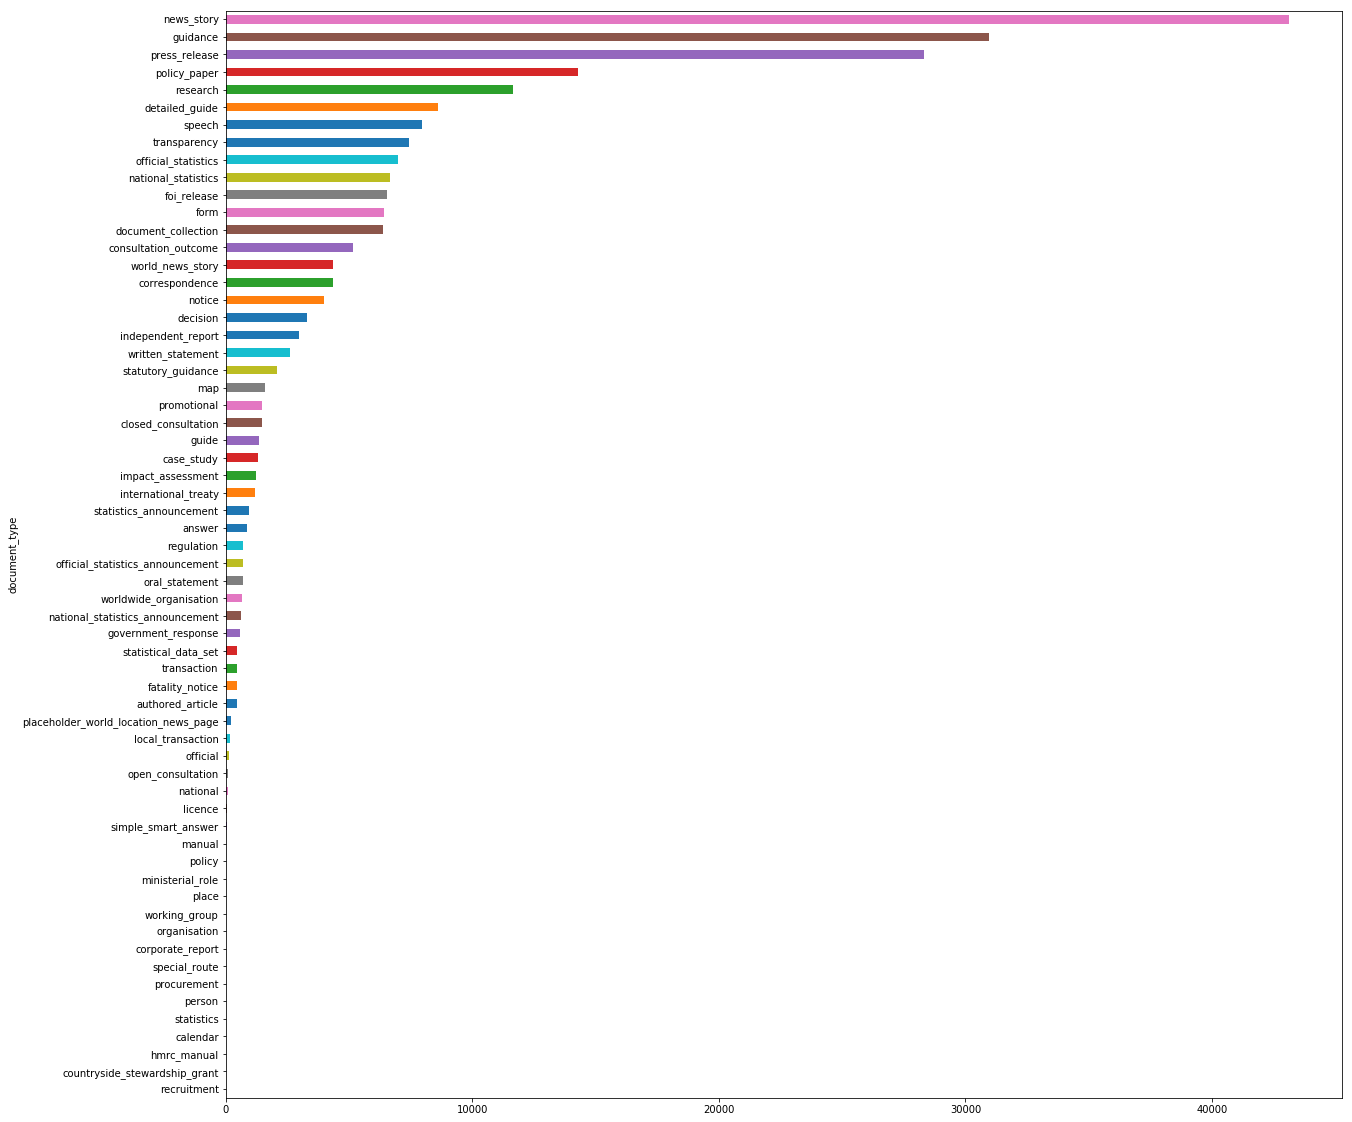

In [529]:
allcontent_taxons.groupby('document_type').size().sort_values(ascending=True).plot(kind = 'barh', figsize=(20, 20))

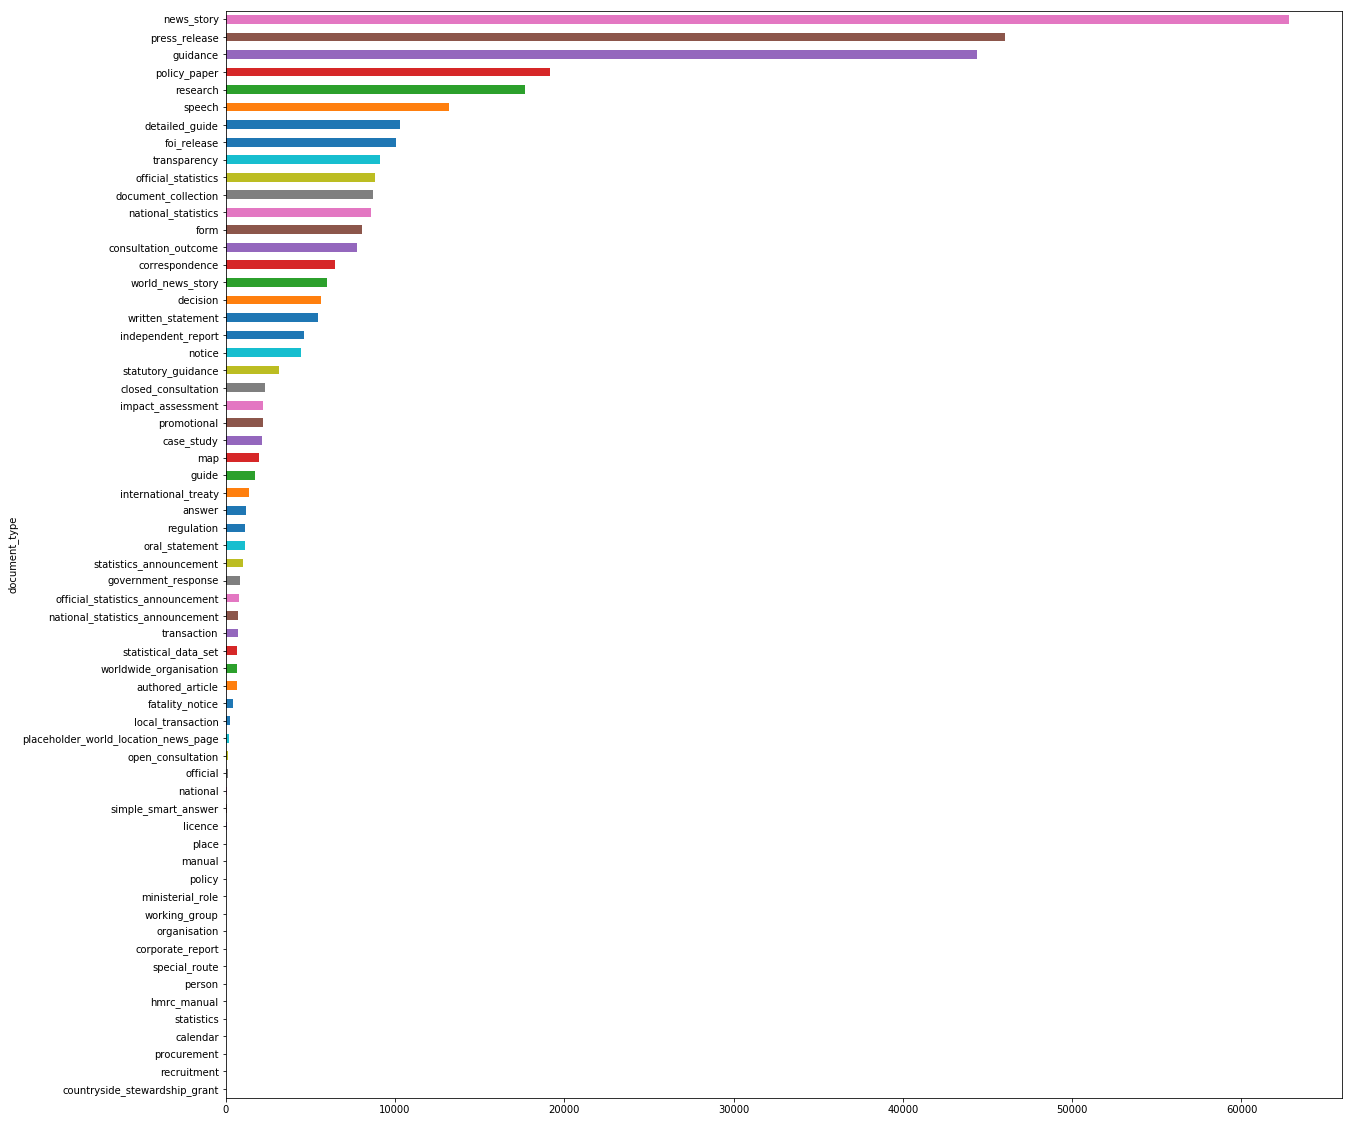

In [530]:
content.groupby('document_type').size().sort_values(ascending=True).plot(kind = 'barh', figsize=(20, 20))

## Time series analyses of content type

What's the frequency of publications over time?

In [531]:
#untagged['first_published_at'].resample('Y').count().plot()

In [532]:
singlelabel = content_taxons_dedup.drop_duplicates('content_id').reset_index(drop=True)
print(singlelabel['first_published_at'][singlelabel['first_published_at'].str.contains('0001-01-01', na=False)])

singlelabel.drop(singlelabel.index[[58843]], inplace=True)
singlelabel['first_published_at'] = pd.to_datetime(singlelabel['first_published_at'])
singlelabel.index = singlelabel['first_published_at'] 

58843    0001-01-01T00:01:00.000+00:00
Name: first_published_at, dtype: object


Focus: since 2000

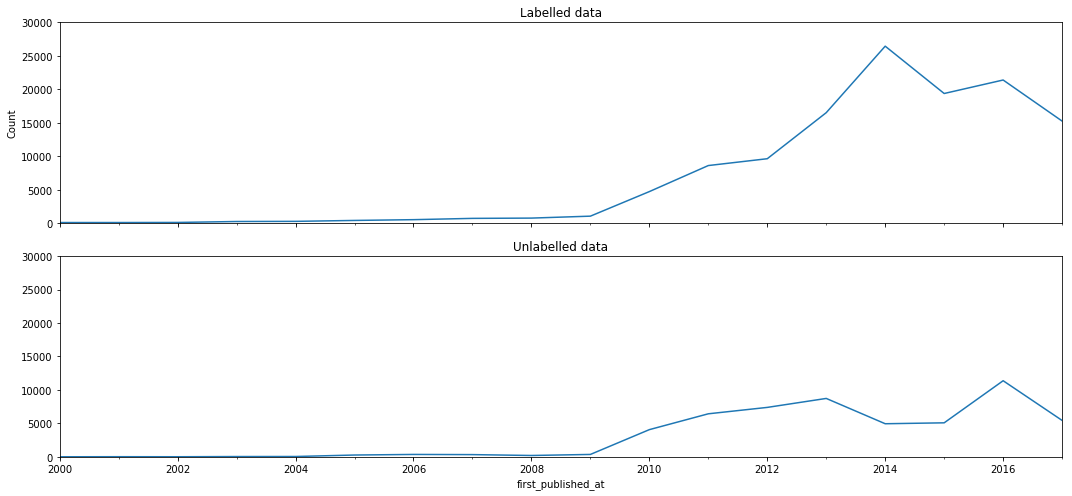

In [533]:
fig = plt.figure(figsize=(15, 7))
plt.subplot(2, 1, 1)
lab=singlelabel['first_published_at'].resample('Y').count().plot()
lab.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2017-12-31'))
plt.title('Labelled data')
plt.ylabel('Count')
lab.set_ylim([0, 30000])
lab.axes.get_xaxis().set_ticklabels([])
lab.set_xlabel('')

plt.subplot(2, 1, 2)
plt.title('Unlabelled data')
unlab = untagged['first_published_at'].resample('Y').count().plot()
unlab.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2017-12-31'))
unlab.set_ylim([0, 30000])

fig.tight_layout()


### What's the publication frequency over time by document type?
### Unlabelled

In [534]:
grouped = untagged.groupby(['document_type', pd.Grouper(freq='Y')])['first_published_at'].count()
count_by_year = grouped.unstack('document_type', fill_value=0)

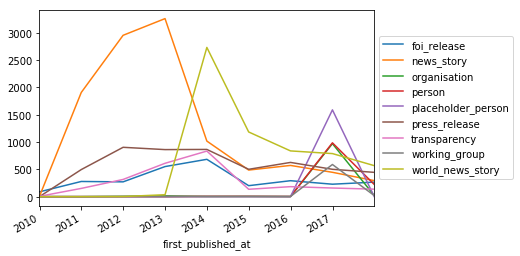

In [535]:
#There are too many document types to plot on one chart so select the types with highest maximum
top_count = count_by_year.loc[:,count_by_year.max() > 500]
ax = top_count.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [536]:
#ax = grouped.unstack('document_type', fill_value=0).plot()
#ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

in order to compare distribution of document types over time with the labelled data, this needs to be relative not absolute. So change into percent of documents published that year

In [537]:
df = count_by_year.stack().reset_index()
df.columns = ['date', 'document_type', 'percent']
bydoctype_year = df.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
bydoctype_pcts = bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)

bydoctype_pcts.columns = bydoctype_pcts.columns.droplevel(0)
bydoctype_pcts.columns

Index(['about', 'answer', 'authored_article',
       'business_finance_support_scheme', 'case_study', 'closed_consultation',
       'consultation_outcome', 'correspondence',
       'countryside_stewardship_grant', 'decision', 'detailed_guide',
       'document_collection', 'drug_safety_update', 'esi_fund',
       'fatality_notice', 'field_of_operation', 'finder', 'foi_release',
       'form', 'government_response', 'guidance', 'guide', 'hmrc_manual',
       'impact_assessment', 'independent_report',
       'international_development_fund', 'international_treaty', 'licence',
       'manual', 'medical_safety_alert', 'ministerial_role', 'national',
       'national_statistics', 'national_statistics_announcement', 'news_story',
       'notice', 'official', 'official_statistics',
       'official_statistics_announcement', 'open_consultation',
       'oral_statement', 'organisation', 'person', 'petitions_and_campaigns',
       'placeholder_ministerial_role', 'placeholder_person',
       'pla

In [538]:

top_pct = bydoctype_pcts.loc[:,bydoctype_pcts.max() > 15]
print(top_pct.columns.values)

# ax = top_pct.plot(kind='area', stacked=True)

# ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.title("Labelled data")

['correspondence' 'decision' 'fatality_notice' 'foi_release' 'guidance'
 'independent_report' 'international_treaty' 'news_story' 'research'
 'world_news_story']


### Labelled

In [539]:
l_grouped = singlelabel.groupby(['document_type', pd.Grouper(freq='Y')])['first_published_at'].count()
l_count_by_year = l_grouped.unstack('document_type', fill_value=0)

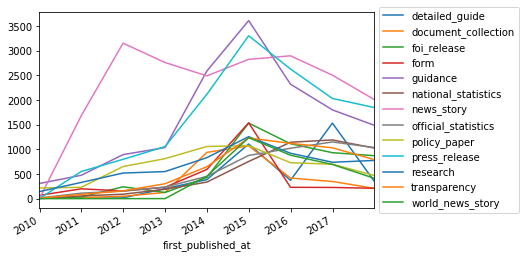

In [540]:
#There are too many document types to plot on one chart so select the types with highest maximum
l_top_count = l_count_by_year.loc[:,l_count_by_year.max() > 1000]
ax = l_top_count.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [541]:
df_lab = l_count_by_year.stack().reset_index()
df_lab.columns = ['date', 'document_type', 'percent']
l_bydoctype_year = df_lab.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
l_bydoctype_pcts = l_bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)

l_bydoctype_pcts.columns = l_bydoctype_pcts.columns.droplevel(0)

In [542]:
l_top_pct = l_bydoctype_pcts[['correspondence', 'decision'
 , 'fatality_notice',  'foi_release',
  'guidance', 'independent_report', 'international_treaty', 'news_story', 'research', 'world_news_story']]

# ax = utop_pct.plot(kind='area', stacked=True)
# plt.title('Unlabelled')
# ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [543]:
type(l_bydoctype_pcts)

pandas.core.frame.DataFrame

#### level1tagged compared to level2tagged

In [544]:
print(level2_dedup['first_published_at'][level2_dedup['first_published_at'].str.contains('0001-01-01', na=False)])
level2_dedup['first_published_at'] = level2_dedup['first_published_at'].str.replace('0001-01-01', '2001-01-01')

print("There were {} content item/taxons before removing duplicates".format(content_taxons_dedup.shape[0]))
print("There were {} content items, unique level2 taxon pairs after removing duplicates by content_id, level1taxon and level2taxon".format(level2_dedup.shape[0]))
mask= pd.notnull(level2_dedup['level2taxon'])
level1_tagged = level2_dedup[~mask].copy()
print("There are {} content items only tagged to level1".format(level1_tagged.shape[0]))
level2_tagged = level2_dedup[mask].copy()
print("There are {} content items tagged to level2 or lower".format(level2_tagged.shape[0]))

print("{} + {} = {}".format(level1_tagged.shape[0], level2_tagged.shape[0], (level1_tagged.shape[0] + level2_tagged.shape[0])) )

86121     0001-01-01T00:01:00.000+00:00
160412    0001-01-01T00:01:00.000+00:00
171948    0001-01-01T00:01:00.000+00:00
208128    0001-01-01T00:01:00.000+00:00
Name: first_published_at, dtype: object
There were 229084 content item/taxons before removing duplicates
There were 203134 content items, unique level2 taxon pairs after removing duplicates by content_id, level1taxon and level2taxon
There are 32034 content items only tagged to level1
There are 171100 content items tagged to level2 or lower
32034 + 171100 = 203134


array(['decision', 'detailed_guide', 'fatality_notice', 'form', 'guidance',
       'independent_report', 'international_treaty', 'national_statistics',
       'news_story', 'notice', 'policy_paper', 'press_release', 'research',
       'statutory_guidance'], dtype=object)

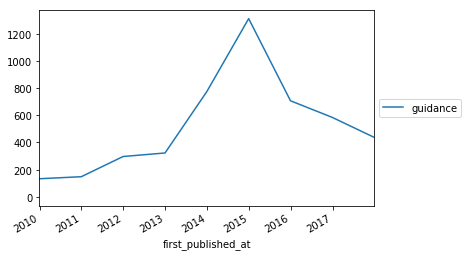

In [545]:
#level1
level1_tagged['first_published_at'] = pd.to_datetime(level1_tagged['first_published_at'])
level1_tagged.index = level1_tagged['first_published_at']


l1_grouped = level1_tagged.groupby(['document_type', pd.Grouper(freq='Y')])['first_published_at'].count()
l1_count_by_year = l1_grouped.unstack('document_type', fill_value=0)
#There are too many document types to plot on one chart so select the types with highest maximum
l1_top_count = l1_count_by_year.loc[:,l1_count_by_year.max() > 1000]
ax = l1_top_count.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
df_l1 = l1_count_by_year.stack().reset_index()
df_l1.columns = ['date', 'document_type', 'percent']
l1_bydoctype_year = df_l1.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
l1_bydoctype_pcts = l1_bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)

l1_bydoctype_pcts.columns = l1_bydoctype_pcts.columns.droplevel(0)
l1_top_pct = l1_bydoctype_pcts.loc[:,l1_bydoctype_pcts.max() > 10]
l1_top_pct.columns.values

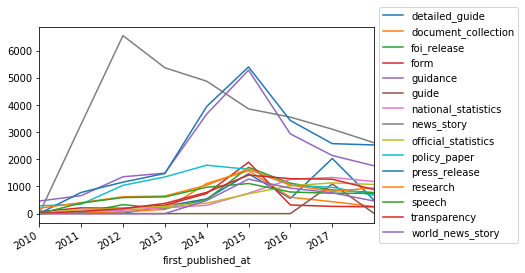

In [546]:
#level2
level2_tagged['first_published_at'] = pd.to_datetime(level2_tagged['first_published_at'])
level2_tagged.index = level2_tagged['first_published_at']


l2_grouped = level2_tagged.groupby(['document_type', pd.Grouper(freq='Y')])['first_published_at'].count()
l2_count_by_year = l2_grouped.unstack('document_type', fill_value=0)
#There are too many document types to plot on one chart so select the types with highest maximum
l2_top_count = l2_count_by_year.loc[:,l2_count_by_year.max() > 1000]

#Graph (absolute numbers)
ax = l2_top_count.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#Relative
df_l2 = l2_count_by_year.stack().reset_index()
df_l2.columns = ['date', 'document_type', 'percent']
l2_bydoctype_year = df_l2.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
l2_bydoctype_pcts = l2_bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)

l2_bydoctype_pcts.columns = l2_bydoctype_pcts.columns.droplevel(0)
l2_top_pct = l2_bydoctype_pcts[['decision', 'guidance', 'independent_report',
       'international_treaty', 'national_statistics', 'news_story',
       'policy_paper', 'press_release', 'research']]

Text(0.5,1,'Percent level2')

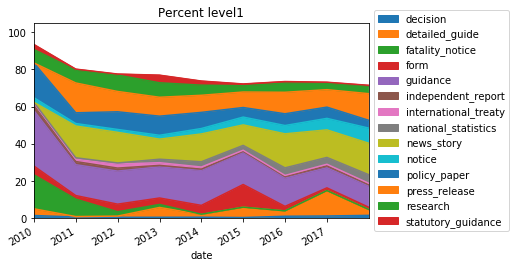

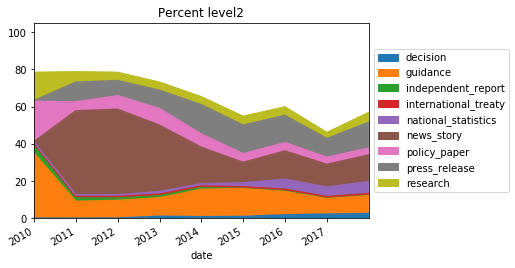

In [547]:
#Compare document type distribution over time beween content items tagged to level1 only and those tagged to level2 or lower
lev1 = l1_top_pct.plot(kind='area', stacked=True)
lev1.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
lev1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Percent level1")

lev2 = l2_top_pct.plot(kind='area', stacked=True)
lev2.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
lev2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Percent level2")

## Compare labelled/unlabelled

Text(0.5,1,'Percent labelled')

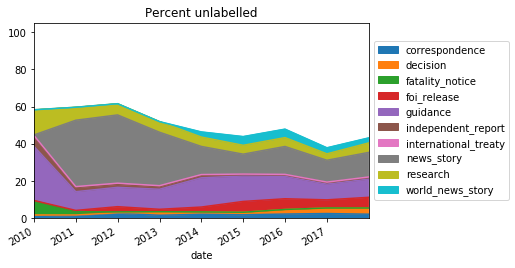

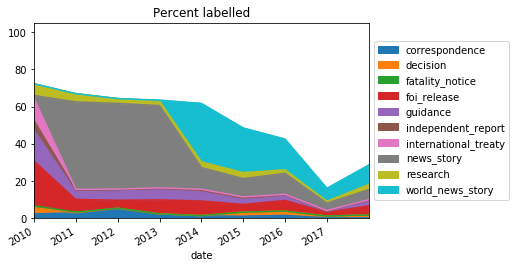

In [548]:
#TO DO: SORT OUT SUBPLOTS
lab = l_top_pct.plot(kind='area', stacked=True)
lab.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
lab.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Percent unlabelled")

unlab = top_pct.plot(kind='area', stacked=True)
unlab.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2017-12-31'))
unlab.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Percent labelled")

To DO: 
- work out subplots
- Look at differences in publishin body/publishing app/ locale/tokenised sequence length over time  
- Tidy up notebook
